# Bono Viaje a la Luna Adaptativo

In [10]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from tqdm import tqdm
import sympy as sym 
import random as rand
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import qexpy as q
from scipy import integrate
from scipy.integrate import odeint

In [11]:
w=2.6617e-6
G=6.67e-11
m_T=5.9736e24
r_T=6.3781e6
m_L=0.07349e24
r_L=1.7374e6
d=3.844e8

In [12]:
dt=5
scale=1000
tiempo=np.arange(0,9e5,dt)
v0 = 11.1e3/d
phi0 = np.deg2rad(45)
theta0 = np.deg2rad(60)
p_r0=v0*np.cos(theta0-phi0)
p_phi0=v0*np.sin(theta0-phi0)*r_T/d

r0 = np.array([r_T/d, phi0, p_r0,p_phi0])

In [13]:
def SystemLuna(r0,t):
    
    r=r0[0]
    phi=r0[1]
    p_r=r0[2]
    p_phi=r0[3]
    
    Delta=G*m_T/d**3
    mu=m_L/m_T
    r_prime=np.sqrt(1+r**2 -2*r*np.cos(phi-w*t))
    
    dr=p_r
    dphi=p_phi/r**2
    dp_r=p_phi**2/r**3 -Delta*(1/r**2 +(mu/r_prime**3)*(r-np.cos(phi-w*t)))
    dp_phi=-Delta*mu*r*np.sin(phi-w*t)/r_prime**3
    
    return np.array([dr,dphi,dp_r,dp_phi])

### Usando Odeint

In [14]:
solreal=integrate.odeint(SystemLuna,r0,tiempo)
dr=solreal[:,0]
dphi=solreal[:,1]
dp_r=solreal[:,2]
dp_phi=solreal[:,3]


In [15]:
x_luna=d*np.cos(w*tiempo)
y_luna=d*np.sin(w*tiempo)
x_satelite=d*dr*np.cos(dphi)
y_satelite=d*dr*np.sin(dphi)

<IPython.core.display.Javascript object>


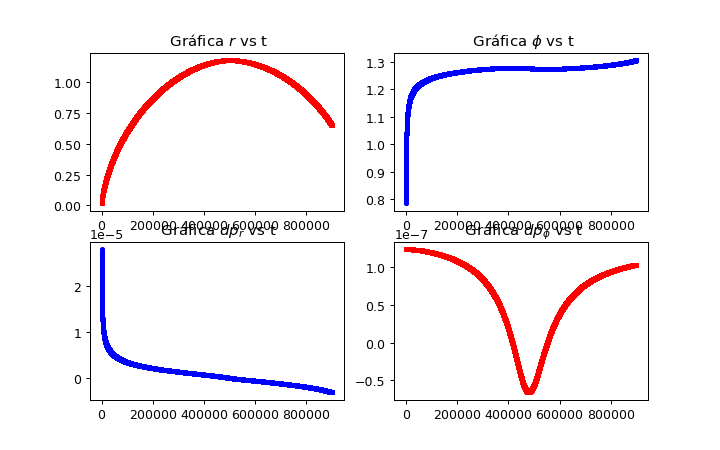

Text(0.5, 1.0, ' Gráfica $dp_\\phi$ vs t')

In [16]:
fig=plt.figure(figsize=(8,5))
ax=fig.add_subplot(221)
ax1=fig.add_subplot(222)
ax2=fig.add_subplot(223)
ax3=fig.add_subplot(224)



ax.scatter(tiempo,dr,color="red",marker='.')
ax1.scatter(tiempo,dphi,color="blue",marker='.')
ax2.scatter(tiempo,dp_r,color="blue",marker='.')
ax3.scatter(tiempo,dp_phi,color="red",marker='.')

ax.set_title(' Gráfica $ r$ vs t ')
ax1.set_title(' Gráfica $ \phi$ vs t')
ax2.set_title(' Gráfica $ dp_r $ vs t')
ax3.set_title(' Gráfica $dp_\phi$ vs t')

<IPython.core.display.Javascript object>


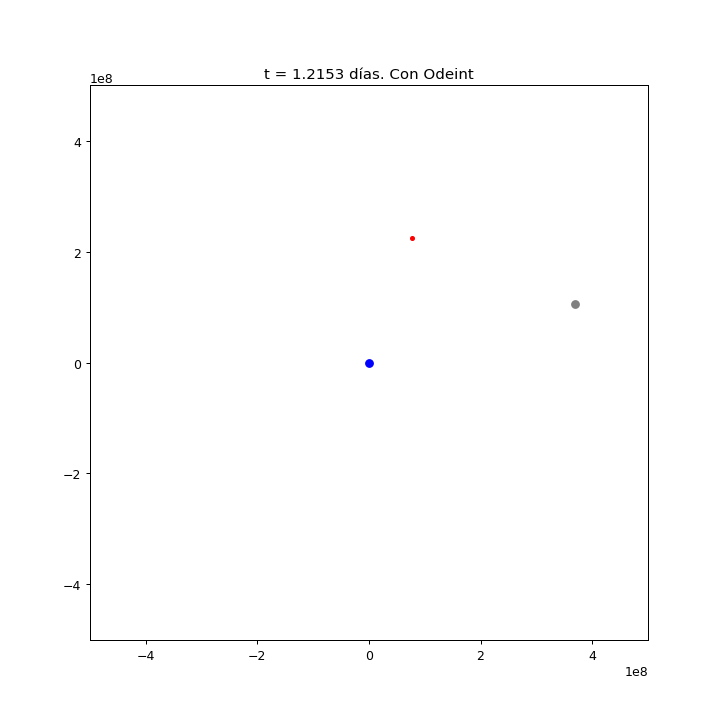

In [17]:
fig4=plt.figure(figsize=(8,8))
ax4=fig4.add_subplot()
t1=tiempo[::scale]*(1/86400)

def init():
    
    ax4.clear()
    ax4.set_xlim(-5e8,5e8)
    ax4.set_ylim(-5e8,5e8)
    
def Update(i):
    init()
    ax4.set_title("t = {:.4f} días. Con Odeint".format(t1[i]))
    ax4.scatter(0,0,color="blue")
    ax4.scatter(x_luna[::scale][i],y_luna[::scale][i],color="gray")
    ax4.scatter(x_satelite[::scale][i],y_satelite[::scale][i],color="red",marker='.')
    

    
Animation = anim.FuncAnimation(fig4,Update,frames=len(t1),init_func=init)


## Adaptativo con Fehlberg

In [18]:
def Increment(f,r0,t,h):

    dr = r0[0]
    dphi = r0[1]
    dp_r = r0[2]
    dp_phi = r0[3]


    state1 = np.array([dr,dphi,dp_r,dp_phi])
    K1 = f(state1,t)

    R = np.array([dr+0.5*h*K1[0],dphi+0.5*h*K1[1],dp_r+0.5*h*K1[2],dp_phi+0.5*h*K1[3]])
    K2 = f(R,t+0.5*h)
        
    R = np.array([dr+0.5*h*K2[0],dphi+0.5*h*K2[1],dp_r+0.5*h*K2[2],dp_phi+0.5*h*K2[3]])
        
    K3=f(R,t+0.5*h)
        
    R = np.array([dr+h*K3[0],dphi+h*K3[1],dp_r+h*K3[2],dp_phi+h*K3[3]])
        
    K4=f(R,t+h)
        
    dr_ = (1/6)*h*(K1[0]+2*K2[0]+2*K3[0]+K4[0])
    dphi_ = (1/6)*h*(K1[1]+2*K2[1]+2*K3[1]+K4[1])
        
    dp_r_ =(1/6)*h*(K1[2]+2*K2[2]+2*K3[2]+K4[2])
    dp_phi_ = (1/6)*h*(K1[3]+2*K2[3]+2*K3[3]+K4[3])
       
    delstas= (1/6)*h*(K1+2*K2+2*K3+K4)
        
        
    Delta=np.array([dr_,dphi_,dp_r_,dp_phi_])
    
    return r0+delstas


In [19]:
def Adaptativo(f,r0,t,e=1e-3):
    
    h=t[1]-t[0]
    
    t_=t[0]
    tf=t[-1]
    
    r=r0
    
    TimeVector=np.array([t])
    Vector=r
    Steps=np.array([h])

    
    while t_ < tf:
        
               
        r1 = Increment(f,r,t_,h)
        r2 = Increment(f,r1,t_+h,h)
        

        rt = Increment(f,r,t_,2*h)

        error = np.linalg.norm( r2 - rt )

        if error < e:
            t_ += 2*h
            r = rt
            Steps=np.append(Steps,h)
            TimeVector=np.append(TimeVector,t_)
            Vector=np.vstack((Vector,r))
            
        else:
            q = 0.85 *(e/error)**(1/4)
            h = h*q
            
            
        
    return TimeVector, Vector, Steps


In [20]:
sol_adapt=Adaptativo(SystemLuna,r0,tiempo)

In [21]:
times,vectors,steps=sol_adapt
drR=vectors[:,0]
dphiR=vectors[:,1]
dp_rR=vectors[:,2]
dp_phiR=vectors[:,3]
t2=np.linspace(0,9e5,len(drR))
len(steps)



90001

In [22]:
x_lunaR=d*np.cos(w*t2)
y_lunaR=d*np.sin(w*t2)
x_sateliteR=d*drR*np.cos(dphiR)
y_sateliteR=d*drR*np.sin(dphiR)

<IPython.core.display.Javascript object>


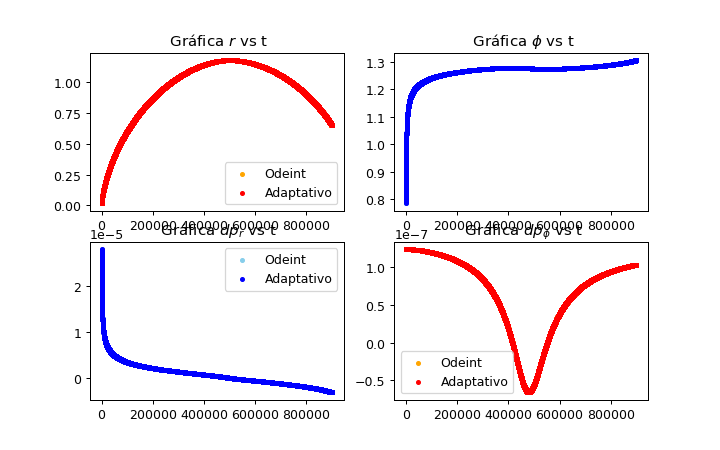

In [23]:
fig2=plt.figure(figsize=(8,5))
ax=fig2.add_subplot(221)
ax1=fig2.add_subplot(222)
ax2=fig2.add_subplot(223)
ax3=fig2.add_subplot(224)




ax.scatter(tiempo,dr,color="orange",marker='.',label='Odeint')
ax1.scatter(tiempo,dphi,color="skyblue",marker='.',label='Odeint')
ax2.scatter(tiempo,dp_r,color="skyblue",marker='.',label='Odeint')
ax3.scatter(tiempo,dp_phi,color="orange",marker='.',label='Odeint')
ax.scatter(t2,drR,color="red",marker='.',label='Adaptativo')
ax1.scatter(t2,dphiR,color="blue",marker='.',label='Adaptativo')
ax2.scatter(t2,dp_rR,color="blue",marker='.',label='Adaptativo')
ax3.scatter(t2,dp_phiR,color="red",marker='.',label='Adaptativo')


ax.set_title(' Gráfica $ r$ vs t ')
ax1.set_title(' Gráfica $ \phi$ vs t')
ax2.set_title(' Gráfica $ dp_r $ vs t')
ax3.set_title(' Gráfica $dp_\phi$ vs t')
ax.legend()
ax2.legend()
ax3.legend()

<IPython.core.display.Javascript object>


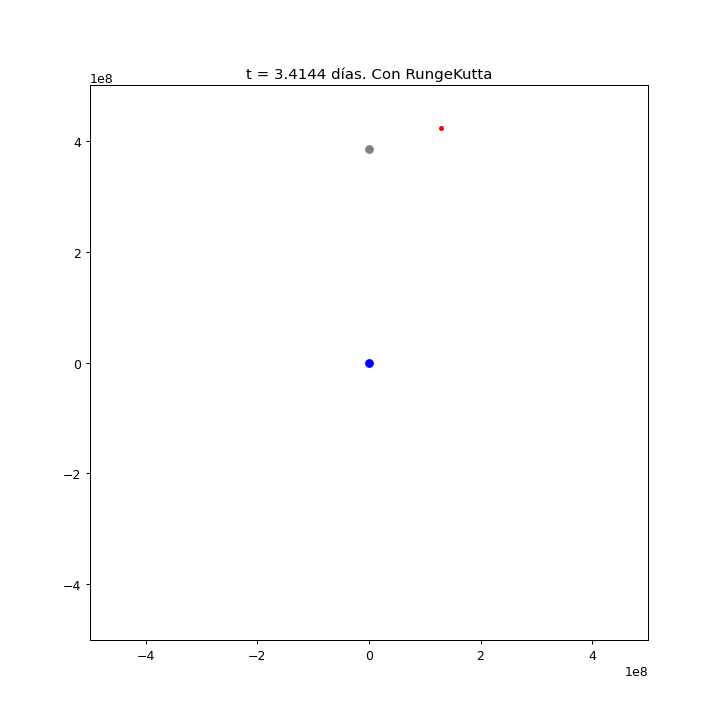

In [24]:
fig5=plt.figure(figsize=(8,8))
ax5=fig5.add_subplot()
t1=tiempo[::scale]*(1/86400)


def init():
    
    ax5.clear()
    ax5.set_xlim(-5e8,5e8)
    ax5.set_ylim(-5e8,5e8)
    
def Update(i):
    init()
    
    x_pasos=x_sateliteR[::scale][:i]
    y_pasos=y_sateliteR[::scale][:i]
    
    ax5.set_title("t = {:.4f} días. Con RungeKutta".format(t1[i]))
    ax5.scatter(0,0,color="blue")
    ax5.scatter(x_lunaR[::scale][i],y_lunaR[::scale][i],color="gray")
    ax5.scatter(x_sateliteR[::scale][i],y_sateliteR[::scale][i],color="red",marker='.')
    
    
Animation = anim.FuncAnimation(fig5,Update,frames=len(t1),init_func=init)